<!-- dom:TITLE: Data Analysis and Machine Learning: Trees, forests and all that -->
# Data Analysis and Machine Learning: Trees, forests and all that
<!-- dom:AUTHOR: Morten Hjorth-Jensen at Department of Physics, University of Oslo & Department of Physics and Astronomy and National Superconducting Cyclotron Laboratory, Michigan State University -->
<!-- Author: -->  
**Morten Hjorth-Jensen**, Department of Physics, University of Oslo and Department of Physics and Astronomy and National Superconducting Cyclotron Laboratory, Michigan State University

Date: **May 19, 2019**

Copyright 1999-2019, Morten Hjorth-Jensen. Released under CC Attribution-NonCommercial 4.0 license






## Decision trees, overarching aims


Decision trees are supervised learning algorithms used for both,
classification and regression tasks.


The main idea of decision trees
is to find those descriptive features which contain the most
**information** regarding the target feature and then split the dataset
along the values of these features such that the target feature values
for the resulting sub datasets are as pure as possible.

The descriptive feature which leaves the target feature most purely is said
to be the most informative one. This process of finding the **most
informative** feature is done until we accomplish a stopping criteria
where we then finally end up in so called **leaf nodes**. 

The leaf nodes
contain the predictions we will make for new query instances presented
to our trained model. This is possible since the model has kind of
learned the underlying structure of the training data and hence can,
given some assumptions, make predictions about the target feature value
(class) of unseen query instances.


A decision tree mainly contains of a **root node**, **interior nodes**,
and **leaf nodes** which are then connected by **branches**.


## How do we set it up?


In simplified terms, the process of training a decision tree and
predicting the target features of query instances is as follows:

1. Present a dataset containing of a number of training instances characterized by a number of descriptive features and a target feature

2. Train the decision tree model by continuously splitting the target feature along the values of the descriptive features using a measure of information gain during the training process

3. Grow the tree until we accomplish a stopping criteria create leaf nodes which represent the *predictions* we want to make for new query instances

4. Show query instances to the tree and run down the tree until we arrive at leaf nodes

Then we are essentially done!





## Decision trees and Regression, our Nuclear data model

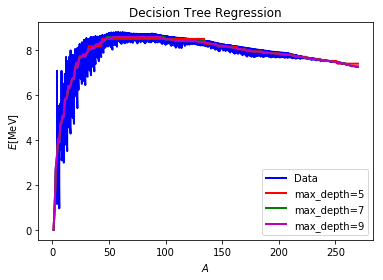

            N    Z    A Element  Ebinding   Eapprox
A                                                  
1   0       0    1    1       H  0.000000  0.000000
2   1       1    1    2       H  1.112283  1.112283
3   2       2    1    3       H  2.827265  2.699972
    3       1    2    3      He  2.572680  2.699972
4   5       3    1    4       H  1.720449  3.316041
    6       2    2    4      He  7.073915  3.316041
    7       1    3    4      Li  1.153760  3.316041
5   8       4    1    5       H  1.336359  4.038208
    9       3    2    5      He  5.512132  4.038208
    10      2    3    5      Li  5.266132  4.038208
6   12      5    1    6       H  0.961639  3.914934
    13      4    2    6      He  4.878519  3.914934
    14      3    3    6      Li  5.332331  3.914934
    15      2    4    6      Be  4.487247  3.914934
7   18      5    2    7      He  4.123057  4.664937
    19      4    3    7      Li  5.606439  4.664937
    20      3    4    7      Be  5.371548  4.664937
    21      

In [2]:
%matplotlib inline

# Regression analysis using scikit-learn functions
# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import os

# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "DataFiles/"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

infile = open(data_path("MassEval2016.dat"),'r')


# Read the experimental data with Pandas
Masses = pd.read_fwf(infile, usecols=(2,3,4,6,11),
              names=('N', 'Z', 'A', 'Element', 'Ebinding'),
              widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),
              header=39,
              index_col=False)

# Extrapolated values are indicated by '#' in place of the decimal place, so
# the Ebinding column won't be numeric. Coerce to float and drop these entries.
Masses['Ebinding'] = pd.to_numeric(Masses['Ebinding'], errors='coerce')
Masses = Masses.dropna()
# Convert from keV to MeV.
Masses['Ebinding'] /= 1000

# Group the DataFrame by nucleon number, A.
Masses = Masses.groupby('A')
# Find the rows of the grouped DataFrame with the maximum binding energy.
Masses = Masses.apply(lambda t: t[t.Ebinding==t.Ebinding])
A = Masses['A']
Z = Masses['Z']
N = Masses['N']
Element = Masses['Element']
Energies = Masses['Ebinding']
# Now we set up the design matrix X
X = np.zeros((1,len(A)))
#X[4,:] = A**(-1.0)
#X[3,:] = A**(-1.0/3.0)
#X[2,:] = A**(2.0/3.0)
X[0,:] = A
#X[0,:] = 1


#Decision Tree Regression
from sklearn.tree import DecisionTreeRegressor
regr_1=DecisionTreeRegressor(max_depth=5)
regr_2=DecisionTreeRegressor(max_depth=7)
regr_3=DecisionTreeRegressor(max_depth=9)
regr_1.fit(X.T, Energies)
regr_2.fit(X.T, Energies)
regr_3.fit(X.T, Energies)


y_1 = regr_1.predict(X.T)
y_2 = regr_2.predict(X.T)
y_3=regr_3.predict(X.T)
Masses['Eapprox'] = y_3
# Plot the results
plt.figure()
plt.plot(A, Energies, color="blue", label="Data", linewidth=2)
plt.plot(A, y_1, color="red", label="max_depth=5", linewidth=2)
plt.plot(A, y_2, color="green", label="max_depth=7", linewidth=2)
plt.plot(A, y_3, color="m", label="max_depth=9", linewidth=2)

plt.xlabel("$A$")
plt.ylabel("$E$[MeV]")
plt.title("Decision Tree Regression")
plt.legend()
save_fig("Masses2016Trees")
plt.show()
print(Masses)
print(np.mean( (Energies-y_3)**2))

## Building a tree, regression

There are mainly two steps
1. We split the predictor space (the set of possible values $x_1,x_2,\dots, x_p$) into $J$

distinct and non-non-overlapping regions, $R_1,R_2,\dots,R_J$.  
1. For every observation that falls into the region $R_j$ , we make the same prediction, which is simply the mean of the response values for the training observations in $R_j$.

How do we construct the regions $R_1,\dots,R_J$? 
In theory, the regions could have any shape. However, we
choose to divide the predictor space into high-dimensional rectangles,
or boxes, for simplicity and for ease of interpretation of the
resulting predic- tive model. The goal is to find boxes $R_1,\dots,R_J$ 
that minimize the MSE, given by

$$
\sum_{j=1}^J\sum_{i\in R_j}(y_i-\overline{y}_{R_j})^2,
$$

where $\overline{y}_{R_j}$  is the mean response for the training observations 
within the $j$th
box. 

## A top-down approach, recursive binary splitting

Unfortunately, it is computationally infeasible to consider every
possible partition of the feature space into $J$ boxes. 
The common strategy is to take a top-down approach

The approach is top-down because it begins at the top of the tree (all
observations belong to a single region) and then successively splits
the predictor space; each split is indicated via two new branches
further down on the tree. It is greedy because at each step of the
tree-building process, the best split is made at that particular step,
rather than looking ahead and picking a split that will lead to a
better tree in some future step.

## Making a tree

In order to implement the recursive binary splitting we start by selecting
the predictor $x_j$ and a cutpoint $s$ that splits the predictor space into two regions $R_1$ and $R_2$

$$
\left\{X\vert x_j < s\right\},
$$

and

$$
\left\{X\vert x_j \geq s\right\},
$$

so that we obtain the lowest MSE, that is

$$
\sum_{i:x_i\in R_j}(y_i-\overline{y}_{R_1})^2+\sum_{i:x_i\in R_2}(y_i-\overline{y}_{R_2})^2,
$$

which we want to minimize by considering all predictors $x_1,x_2,\dots,x_p$.
We consider also all possible values of $s$ for each predictor. These values could be determined by randomly assigned numbers or by starting at the midpoint and then proceed till we find an optimal value.

For any $j$ and $s$, we define the pair of
half-planes where $\overline{y}_{R_1}$ is the mean response for the training
observations in $R_1(j,s)$, and $\overline{y}_{R_2}$ is the mean response for the
training observations in $R_2(j,s)$. 

Finding the values of j and s that
minimize the above equation can be done quite quickly, especially when the number
of features $p$ is not too large.  

Next, we repeat the process, looking
for the best predictor and best cutpoint in order to split the data
further so as to minimize the MSE within each of the resulting
regions. However, this time, instead of splitting the entire predictor
space, we split one of the two previously identified regions. We now
have three regions. Again, we look to split one of these three regions
further, so as to minimize the MSE. The process continues until a
stopping criterion is reached; for instance, we may continue until no
region contains more than five observations.

<!-- !split  -->
## Pruning the tree

The above procedure is rather straightforward, but leads often to
overfitting and unnecessarily large and complicated trees. The basic
idea is to grow a large tree $T_0$ and then prune it back in order to
obtain a subtree. A smaller tree with fewer splits (fewer regions) can
lead to smaller variance and better interpretation at the cost of a
little more bias.

The so-called Cost complexity pruning algorithm gives us a
way to do just this. Rather than considering every possible subtree,
we consider a sequence of trees indexed by a nonnegative tuning
parameter $\alpha$.

## Cost complexity pruning
For each value of $\alpha$  there corresponds a subtree $T \in T_0$ such that

$$
\sum_{m=1}^{\overline{T}}\sum_{i:x_i\in R_m}(y_i-\overline{y}_{R_m})^2+\alpha\overline{T},
$$

is as small as possible. Here $\overline{T}$ is 
the number of terminal nodes of the tree $T$ , $R_m$ is the
rectangle (i.e. the subset of predictor space)  corresponding to the $m$-th terminal node.

The tuning parameter $\alpha$ controls a trade-off between the subtree’s
com- plexity and its fit to the training data. When $\alpha = 0$, then the
subtree $T$ will simply equal $T_0$, 
because then the above equation just measures the
training error. 
However, as $\alpha$ increases, there is a price to pay for
having a tree with many terminal nodes. The above equation will
tend to be minimized for a smaller subtree. 


It turns out that as we increase $\alpha$ from zero
branches get pruned from the tree in a nested and predictable fashion,
so obtaining the whole sequence of subtrees as a function of $\alpha$ is
easy. We can select a value of $\alpha$ using a validation set or using
cross-validation. We then return to the full data set and obtain the
subtree corresponding to $\alpha$. 


## A schematic procedure

**Building a Regression Tree.**

1. Use recursive binary splitting to grow a large tree on the training data, stopping only when each terminal node has fewer than some minimum number of observations.

2. Apply cost complexity pruning to the large tree in order to obtain a sequence of best subtrees, as a function of $\alpha$.

3. Use for example $K$-fold cross-validation to choose $\alpha$. Divide the training observations into $K$ folds. For each $k=1,2,\dots,K$ we: 

  * repeat steps 1 and 2 on all but the $k$-th fold of the training data. 

  * Then we valuate the mean squared prediction error on the data in the left-out $k$-th fold, as a function of $\alpha$.

  * Finally  we average the results for each value of $\alpha$, and pick $\alpha$ to minimize the average error.


4. Return the subtree from Step 2 that corresponds to the chosen value of $\alpha$.




## A classification tree

A classification tree is very similar to a regression tree, except
that it is used to predict a qualitative response rather than a
quantitative one. Recall that for a regression tree, the predicted
response for an observation is given by the mean response of the
training observations that belong to the same terminal node. In
contrast, for a classification tree, we predict that each observation
belongs to the most commonly occurring class of training observations
in the region to which it belongs. In interpreting the results of a
classification tree, we are often interested not only in the class
prediction corresponding to a particular terminal node region, but
also in the class proportions among the training observations that
fall into that region.  

## Growing a classification tree

The task of growing a
classification tree is quite similar to the task of growing a
regression tree. Just as in the regression setting, we use recursive
binary splitting to grow a classification tree. However, in the
classification setting, the MSE cannot be used as a criterion for making
the binary splits.  A natural alternative to MSE is the **classification
error rate**. Since we plan to assign an observation in a given region
to the most commonly occurring error rate class of training
observations in that region, the classification error rate is simply
the fraction of the training observations in that region that do not
belong to the most common class. 

When building a classification tree, either the Gini index or the
entropy are typically used to evaluate the quality of a particular
split, since these two approaches are more sensitive to node purity
than is the classification error rate. 


## Classification tree, how to split nodes
If our targets are the outcome of a classification process that takes for example 
$k=1,2,\dots,K$ values, the only thing we need to think of is to set up the splitting criteria for each node.

We define a PDF $p_{mk}$  that represents the number of observations of a class $k$ in a region $R_m$ with $N_m$ observations. We represent this likelihood function in terms of the proportion $I(y_i=k)$  of observations of this class in the region $R_m$ as

$$
p_{mk} = \frac{1}{N_m}\sum_{x_i\in R_m}I(y_i=k).
$$

We let $p_{mk}$ represent the majority class of observations in region $m$. The three most common ways of splitting a node are given by 
* Misclassification error

$$
p_{mk} = \frac{1}{N_m}\sum_{x_i\in R_m}I(y_i\ne k) = 1-p_{mk}.
$$

* Gini index $g$

$$
g = \sum_{k=1}^K p_{mk}(1-p_{mk}).
$$

* Information entropy or just entropy $s$

$$
s = -\sum_{k=1}^K p_{mk}\log{p_{mk}}.
$$

## Back to moons again

In [2]:
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


from sklearn.svm import SVC
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_moons
from sklearn.tree import export_graphviz

Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)


def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris-Virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)
plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.subplot(122)
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)
plt.show()

## Playing around with regions

In [3]:
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.subplot(122)
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)

plt.show()

## Regression trees

In [4]:
# Quadratic training set + noise
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [5]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

## Final regressor code

In [6]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.subplot(122)
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

plt.show()

In [7]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.subplot(122)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

plt.show()

## Pros and cons of trees, pros

* White box, easy to interpret model. Some people believe that decision trees more closely mirror human decision-making than do the regression and classification approaches discussed earlier (think of support vector machines)

* Trees are very easy to explain to people. In fact, they are even easier to explain than linear regression!

* No feature normalization needed

* Tree models can handle both continuous and categorical data (Classification and Regression Trees)

* Can model nonlinear relationships

* Can model interactions between the different descriptive features

* Trees can be displayed graphically, and are easily interpreted even by a non-expert (especially if they are small)

## Disadvantages

* Unfortunately, trees generally do not have the same level of predictive accuracy as some of the other regression and classification approaches

* If continuous features are used the tree may become quite large and hence less interpretable

* Decision trees are prone to overfit the training data and hence do not well generalize the data if no stopping criteria or improvements like pruning, boosting or bagging are implemented

* Small changes in the data may lead to a completely different tree. This issue can be addressed by using ensemble methods like bagging, boosting or random forests

* Unbalanced datasets where some target feature values occur much more frequently than others may lead to biased trees since the frequently occurring feature values are preferred over the less frequently occurring ones. 

* If the number of features is relatively large (high dimensional) and the number of instances is relatively low, the tree might overfit the data

* Features with many levels may be preferred over features with less levels since for them it is *more easy* to split the dataset such that the sub datasets only contain pure target feature values. This issue can be addressed by preferring for instance the information gain ratio as splitting criteria over information gain

However, by aggregating many decision trees, using methods like bagging, random forests, and boosting, the predictive performance of trees can be substantially improved. 

## Bagging

The **plain** decision trees suffer from high
variance. This means that if we split the training data into two parts
at random, and fit a decision tree to both halves, the results that we
get could be quite different. In contrast, a procedure with low
variance will yield similar results if applied repeatedly to distinct
data sets; linear regression tends to have low variance, if the ratio
of $n$ to $p$ is moderately large. 

**Bootstrap aggregation**, or just **bagging**, is a
general-purpose procedure for reducing the variance of a statistical
learning method. 


Bagging typically results in improved accuracy
over prediction using a single tree. Unfortunately, however, it can be
difficult to interpret the resulting model. Recall that one of the
advantages of decision trees is the attractive and easily interpreted
diagram that results.

However, when we bag a large number of trees, it is no longer
possible to represent the resulting statistical learning procedure
using a single tree, and it is no longer clear which variables are
most important to the procedure. Thus, bagging improves prediction
accuracy at the expense of interpretability.  Although the collection
of bagged trees is much more difficult to interpret than a single
tree, one can obtain an overall summary of the importance of each
predictor using the MSE (for bagging regression trees) or the Gini
index (for bagging classification trees). In the case of bagging
regression trees, we can record the total amount that the MSE is
decreased due to splits over a given predictor, averaged over all $B$ possible
trees. A large value indicates an important predictor. Similarly, in
the context of bagging classification trees, we can add up the total
amount that the Gini index  is decreased by splits over a given
predictor, averaged over all $B$ trees.

## Random forests

Random forests provide an improvement over bagged trees by way of a
small tweak that decorrelates the trees. 

As in bagging, we build a
number of decision trees on bootstrapped training samples. But when
building these decision trees, each time a split in a tree is
considered, a random sample of $m$ predictors is chosen as split
candidates from the full set of $p$ predictors. The split is allowed to
use only one of those $m$ predictors. 

A fresh sample of $m$ predictors is
taken at each split, and typically we choose

$$
m\approx \sqrt{p}.
$$

In building a random forest, at
each split in the tree, the algorithm is not even allowed to consider
a majority of the available predictors. 

The reason for this is rather clever. Suppose that there is one very
strong predictor in the data set, along with a number of other
moderately strong predictors. Then in the collection of bagged
variable importance random forest trees, most or all of the trees will
use this strong predictor in the top split. Consequently, all of the
bagged trees will look quite similar to each other. Hence the
predictions from the bagged trees will be highly correlated. 
Unfortunately, averaging many highly correlated quantities does not lead
to as large of a reduction in variance as averaging many uncorrelated
quanti- ties. In particular, this means that bagging will not lead to
a substantial reduction in variance over a single tree in this
setting.  

## A simple scikit-learn example

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
# Data set not specificied
X = dataset.XXX
Y = dataset.YYY
#Instantiate the model with 100 trees and entropy as splitting criteria
Random_Forest_model = RandomForestClassifier(n_estimators=100,criterion="entropy")
#Cross validation
accuracy = cross_validate(Random_Forest_model,X,Y,cv=10)['test_score']

## Please, not the moons again!

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

In [10]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

In [11]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

In [12]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

## Bagging examples

In [13]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [14]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

In [15]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

In [16]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.show()

## Then random forests

In [17]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)

In [18]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)
np.sum(y_pred == y_pred_rf) / len(y_pred)